# Figures 3, 4 and 7: Multi-Point Observations

Comparison between PSP, Solar Orbiter, MMS, and Wind (1AU) measurements.

- Panel (a): $M_A$
- Panel (b): $\sigma_C$
- Panel (c): $v_R$ [km/s]
- Panel (d): $B_r R^2$ [nT]
- Panel (e): $N_P R^2$ [cm^{-3}]
- Panel (f): $\beta$
- Panel (g): Trajectories (lon/lat) [deg]

In [1]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats

import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
import tools.psp_funcs as psp_funcs
from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker
from scipy.signal.windows import tukey

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [59.5, 62]
loc_hcs1 = [357.7, 357.9]
ssw = [9, 25]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']
linec, linew = 'red', 3
# DIRECTORIES
RES_DIR = os.path.join('/Users/tamarervin/', 'e15_results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

08-Mar-24 10:48:53: /Users/tamarervin/anaconda3/envs/psp38/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Read in Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, pflag=False)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

### UPDATE WIND DATAFRAME ###
wind['MA'] = np.abs(wind.MA)
wind['vr'] = np.abs(wind.vr)
wind['sigmac'] = -1*wind.sigmac
winddownt = utils.time_resample([wind])[0]
winddownt['Time'] = winddownt.index
winddownl = utils.lon_bin(wind, vv='sslon')

08-Mar-24 10:48:57: /Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Mar-24 10:48:57: /Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Mar-24 10:48:59: /Users/tamarervin/publications/e15/tools/utilities.py:181: FutureWarning: 'loffset' in .resample() and in Grouper() is d

In [3]:
plon = utils.rollto180(np.array(parkerdownl.sslon)*u.deg)
olon = utils.rollto180(np.array(orbiterdownl.sslon)*u.deg)
wlon = utils.rollto180(np.array(winddownl.sslon)*u.deg)

# Trajectories

## Parker and Orbiter

In [4]:
dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
def gen_dt_arr(dt_init,dt_final,cadence_days=1) :
    """
    Get array of datetime.datetime from {dt_init} to {dt_final} every 
    {cadence_days} days
    """
    dt_list = []
    while dt_init < dt_final :
        dt_list.append(dt_init)
        dt_init += datetime.timedelta(days=cadence_days)
    return np.array(dt_list)

### GENERATE TIME ARRAYS
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

### GENERATE VELOCITY ARRAYS
psp_vr_common = interp1d(np.array([dt.timestamp() for dt in parker.Time]),parker.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_common = interp1d(np.array([dt.timestamp() for dt in orbiter.Time]),orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s

In [5]:
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter',dt_common
)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

In [6]:
# Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py

@u.quantity_input
def delta_long(r:u.R_sun,
               r_inner=2.5*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to("deg")

def ballistically_project(skycoord,r_inner = 2.5*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [7]:
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

## Wind Trajectory

In [8]:
import astropy.constants as const
import heliopy.spice as spice
import scipy.constants as con

def get_sc_trajectory(datetime_arr,spice_str='SPP',
                      origin='Sun',frame='IAU_SUN',
                      representation_type="cartesian",
                      incl_datetimes = False
                      ) :
    if spice_str == 'L1':
        spice_str = 'Earth'
        modifier= 1.0- ((const.M_earth.value/
                        (const.M_earth.value
                         +const.M_sun.value))/3)**(1/3)
    else : modifier= 1.0
    try : sc = spice.Trajectory(spice_str)
    except :
        valid_strings = [
        'SPP','Earth','L1','SOLO', 'Venus', 'BEPICOLOMBO MPO',
        ]
        return f"Invalid spice string, choose from {valid_strings}"
    sc.generate_positions(datetime_arr, origin, frame)
    sc.change_units(u.au)
    if len(datetime_arr) == 1 or not incl_datetimes:
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = datetime_arr[0],
                                  )
    else :
        sc_coord = SkyCoord(x=sc.x*modifier,
                                  y=sc.y*modifier,
                                  z=sc.z*modifier,
                                  frame= sunpy.coordinates.HeliographicCarrington,
                                  representation_type='cartesian',
                                  observer="Earth",
                                  obstime = list(datetime_arr),
                                  )
    sc_coord.representation_type=representation_type
    return sc_coord

In [9]:
l1_factor = 0.99029
wind_carrington = get_sc_trajectory(dt_common, spice_str='L1')
wind_carrington.representation_type = 'spherical'
# wind_carrington = SkyCoord(lon=wind_carrington.lon, lat=wind_carrington.lat, radius=wind_carrington.radius*l1_factor, 
#                            representation_type="spherical", frame=wind_carrington.frame)

wind_vr_ts = [int(dt.timestamp()) for dt in wind.Time]
wind_vr_common = interp1d(wind_vr_ts, wind.vr, bounds_error=False)(ts_common)*u.km/u.s
wind_projected = psp_funcs.ballistically_project(wind_carrington, vr_arr=wind_vr_common, r_inner=2.5*u.R_sun)

## MMS Trajectory

In [10]:
### MMS Composition Data
mms = pd.read_csv(os.path.join(RES_DIR, 'mms.csv'))
mms['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in mms.Time]
mms.columns
mms['beta'] = mms.betap
mms['MA'] = np.abs(mms.MA)

In [11]:
### MMS Bow Shock Crossings
bowshock = pd.read_csv(os.path.join(RES_DIR, 'bowShockCrossings.txt'), sep=', ', index_col=None)
bowshock['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in bowshock.Time]
inbound = bowshock.iloc[np.where(bowshock=='IB')[0]].copy()
outbound = bowshock.iloc[np.where(bowshock=='OB')[0]].copy()

### MMS Magnetosphere Events
magnetosphere = pd.read_csv(os.path.join(RES_DIR, 'magnetosphereEventList.txt'), sep=', ', index_col=None)
magnetosphere['TimeIn'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeIn]
magnetosphere['TimeOut'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeOut]


08-Mar-24 10:49:04: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_1727/2684704813.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bowshock = pd.read_csv(os.path.join(RES_DIR, 'bowShockCrossings.txt'), sep=', ', index_col=None)

08-Mar-24 10:49:04: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_1727/2684704813.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  magnetosphere = pd.read_csv(os.path.join(RES_DIR, 'magnetosphereEventList.txt'), sep=', ', index_col=None)



In [12]:
files = np.sort(glob.glob(os.path.join(RES_DIR, (os.path.join('pydata/mms1/mec/srvy/l2/epht89q/2023/03/', "*"))), recursive=True))
import cdflib
time, Xgse, Ygse, Zgse = [], [], [], []
# coords, tt = [], []
for f in files:
    data_cdf = cdflib.CDF(f) 
    ### READ IN VARIABLE INFO
    time.extend((cdflib.cdfepoch.to_datetime(data_cdf.varget("Epoch"))))
    Xgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 0]))
    Ygse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 1]))
    Zgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 2]))

    # ### READ IN VARIABLE INFO
    # time = cdflib.cdfepoch.to_datetime(data_cdf.varget("Epoch"))
    # Xgse = data_cdf.varget("mms1_mec_r_gse")[:, 0]
    # Ygse = data_cdf.varget("mms1_mec_r_gse")[:, 1]
    # Zgse = data_cdf.varget("mms1_mec_r_gse")[:, 2]


    ### ADD TO LIST
    # tt.append(time)
    # coords.append(mms_carrington)


In [13]:
### TRANSFORM TO HELIOGRAPHIC CARRINGTON
mms1_gse = SkyCoord(np.array(Xgse)*u.km, np.array(Ygse)*u.km, np.array(Zgse)*u.km, frame=sunpy.coordinates.frames.GeocentricSolarEcliptic, representation_type='cartesian', obstime=np.array(time))
mms_carrington = mms1_gse.transform_to(
    scoords.HeliographicCarrington(observer="self"))
mms_carrington.representation_type = 'spherical'
dt_start,dt_end = datetime.datetime(2023,3,21),datetime.datetime(2023,4,1)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/(48*60))
ts_common = np.array([dt.timestamp() for dt in dt_common])
mms_vr_ts = [int(dt.timestamp()) for dt in mms.Time]
mms_vr_common = interp1d(mms_vr_ts, mms.vr, bounds_error=False)(ts_common)*u.km/u.s
mms_projected = psp_funcs.ballistically_project(mms_carrington, vr_arr=mms_vr_common, r_inner=2.5*u.R_sun)

mms_df = pd.DataFrame(data={'Time':dt_common, 'sslon':mms_projected.lon.value, 
                            'sslat':mms_projected.lat,
                            'rAU':mms_carrington.radius.to(u.AU).value})
mms_df = mms_df.set_index(mms_df.Time)
mms_df = mms_df.drop(['Time'], axis=1)
mms_df

,sslon,sslat,rAU
Time,,,
2023-03-21 00:00:00,256.478668,-7.031205,0.995873
2023-03-21 00:00:30,256.999175,-7.031199,0.995873
2023-03-21 00:01:00,269.518133,-7.031193,0.995872
2023-03-21 00:01:30,248.691440,-7.031187,0.995872
2023-03-21 00:02:00,253.340211,-7.031181,0.995871
...,...,...,...
2023-03-31 23:57:30,NaN,-6.579004,0.998537
2023-03-31 23:58:00,NaN,-6.578992,0.998537
2023-03-31 23:58:30,NaN,-6.578980,0.998537


In [14]:
mms = mms.set_index(mms.Time)
mms = utils.time_resample([mms],  bin_size= pd.Timedelta(seconds=30))[0]
# mms = pd.merge_asof(mms, mms_df, on='Time', direction='backward')
# mms['NpR2'] = mms.Np * (mms.rAU**2)
# mmsdownl = utils.lon_bin(mms, vv='sslon')
# mmsdownl['vr'] = np.abs(mmsdownl.vr)

08-Mar-24 10:49:23: /Users/tamarervin/publications/e15/tools/utilities.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd = df.resample(bin_size, closed='left').mean()



## Multispacecraft Observations Figure

In [15]:
mmso = mms.copy()
mms['Time'] = mms.index.to_list()
mms = mms[np.logical_and(mms.Time>= pd.Timestamp('2023-03-24'), mms.Time<= pd.Timestamp('2023-03-31'))].copy()

In [16]:
dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)

NameError: name 'parker_streamline' is not defined

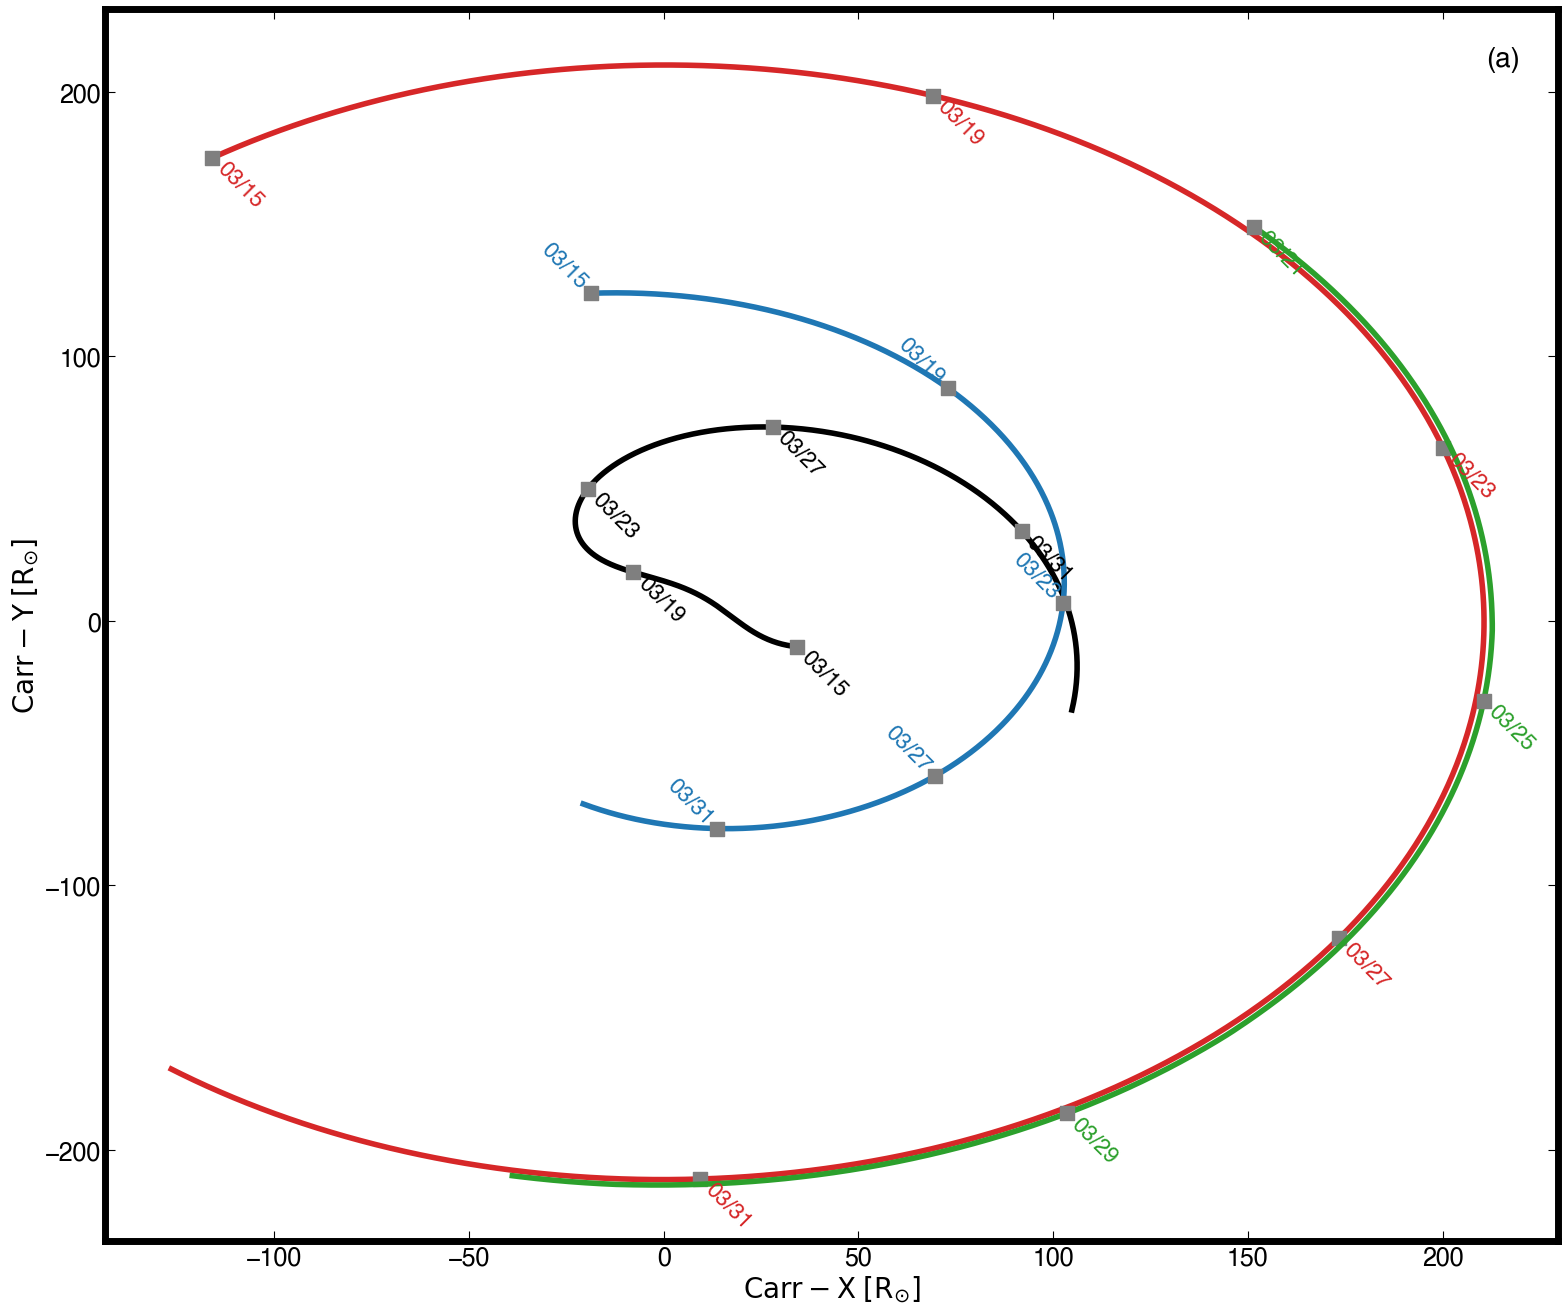

In [17]:
##### ------------------------------------------------------ ######
              ##### ---------- SETUP  ---------- ######
##### ------------------------------------------------------ ######
fig = plt.figure(figsize=(45, 16))
gs = plt.GridSpec(4, 3, width_ratios=[4, 2.5, 2.5], hspace=0, wspace=0.1)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm M_A$', ### Mach number
            r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
            r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
            r'$\rm \beta$', ### plasma beta
            ]

### DEFINE DATA, LABELS, COLORMAPS
data = ['MA', 'vr', 'NpR2', 'beta'] #, 'sslat']
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
rcol='grey'
lw, ss = 4, 100
cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green']
##### ------------------------------------------------------ ######
    ##### ---------- RIGHT COLUMN (ORBITS)  ---------- ######
##### ------------------------------------------------------ ######
ax = plt.subplot(gs[:, 0])
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel(r'$\rm Carr-X \; [R_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\rm Carr-Y \; [R_{\odot}]$', fontsize=20)
ax.text(0.95, 0.97, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
ax.plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=lw,label="PSP",zorder=10
)
ax.scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### ORBITER
solo_carrington.representation_type="cartesian"
ax.plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=lw,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### WIND
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=lw,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::label_cadence],
    wind_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### MMS
mc= 2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=lw,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10, s=ss
)

### LABEL DATES
for dt,pspc,soc,wsc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence], 
                       wind_carrington[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


### SHADE SA STREAM
############ SA STREAM
for xx in np.arange(400, 500, step=1):
    pcoords = parker_streamline(projected=psp_projected[85],
                    r0 = 2.5*u.R_sun,
                    rmax = 400*u.R_sun,
                    v_sw=xx *u.km/u.s
                    )
    ax.plot(pcoords[0].x.value, pcoords[0].y.value,
                    color=scol,linewidth=3,zorder=-1) 
    ax.plot(pcoords[1].x.value, pcoords[1].y.value,
                    color=scol,linewidth=3,zorder=-1) 
    # ax.fill_between(pcoords[0].x.value, pcoords[0].y.value, pcoords[1].y.value, color=scol)
    # ax.fill_betweenx(pcoords[1].y.value, pcoords[0].x.value, pcoords[1].x.value, color=scol)
    
### Gridlines / Axis Lables ETC for axes[0]
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xticks(np.linspace(-300,300,7))
ax.set_yticks(np.linspace(-300,300,7))
ax.set_xlim([-300,300])
ax.set_ylim([-300,300])
# ax.set_xticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)
# ax.set_yticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)

### LEGEND ###
psp = mpatches.Patch(edgecolor='k', facecolor=cp,  label= r'$\rm Parker \; Solar \; Probe$')
solo = mpatches.Patch(edgecolor='k', facecolor=cs,  label= r'$\rm Solar \; Orbiter$')
acep = mpatches.Patch(edgecolor='k', facecolor=ca,  label= r'$\rm Wind$')
mmsp = mpatches.Patch(edgecolor='k', facecolor=cm,  label= r'$\rm MMS$')
sa_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label=r'$\rm SA \; Stream$')
leg0 = ax.legend(handles=[psp, solo, acep, mmsp,sa_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

##### ------------------------------------------------------------ ######
##### ---------- LEFT COLUMN (PARKER, ORBITER, WIND)  ---------- ######
##### ------------------------------------------------------------ ######
axs = [plt.subplot(gs[i, 1]) for i in np.arange(0, 4)]
# axs[0].set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=26)

##### ---------- PARKER DATA  ---------- ######
for i, vv in enumerate(data):
    ### PLOT THE DATA
    axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
    axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
    axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
    # axs[i].step(mmsdownl.sslon, mmsdownl[vv], c=cm, linewidth=lw, zorder=2)

    axs[i].set_xticklabels([])

    ### ADD Y-LABEL
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 

    ### ADD X-LIMITS
    axs[i].set(xlim=(-5, 35), xticks=np.arange(0, 31, step=10))

    ### ADD THE GRID
    axs[i].grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS ###
    regions = [
        (loc_hcs[0], loc_hcs[1], hcol),
        (loc_hcs1[0], loc_hcs1[1], hcol),
        (ssw[0], ssw[1], scol),
        (fsw[0], fsw[1], fcol)
    ]

    lines = [
        loc_hcs[0],
        loc_hcs[1],
        loc_hcs1[0],
        loc_hcs1[1],
        ssw[0],
        ssw[1],
        fsw[0],
        fsw[1]
    ]

    ### PLOT LINES AND REGIONS ###
    for line in lines:
        axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

    for region in regions:
        axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    axs[i].text(0.93, 0.93, panel_labels[i+1], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### X TICK LABELS
axs[i].set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 10^{\circ}$', r'$\rm 20^{\circ}$', r'$\rm 30^{\circ}$'], fontsize=18)
axs[i].set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)

### AXES AND TICK MARKS ###
ytick_log = [0.01, 0.1, 1.0, 10, 100]
ylab_log = [str(val) for val in ytick_log]
axs[0].set(ylim=(-1, 7), yticks=np.arange(0, 6.1, step=2)) ## mach number
axs[1].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
axs[2].set_yscale('log') ## proton density
axs[3].set_yscale('log') ## plasma beta
# axs[4].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

### PLOT MARKINGS ###
axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
axs[1].axhline(500, color='k', linestyle='dashed') ## radial velocity
# axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
axs[2].axhline(4, color='k', linestyle='dashed') ## proton density
axs[3].axhline(1, color='k', linestyle='dashed') ## plasma beta


##### ------------------------------------------------------ ######
        ##### ---------- RIGHT COLUMN (MMS)  ---------- ######
##### ------------------------------------------------------ ######
ss, swc = 2, 'lemonchiffon'
axs = [plt.subplot(gs[i, 2]) for i in np.arange(0, 4)]
# axs[0].set_title(r'$\rm MMS \; Observations$', fontsize=26)
ylabels = [r'$\rm M_A$', r'$\rm v_{H^+} \; [km s^{-1}]$', r'$\rm N_{H^{+}} \; [cm^{-3}]$', r'$\rm \beta$']

### REGIONS
regions = [# (magnetosphere.TimeOut[1], magnetosphere.TimeIn[2], swc), 
            (magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], swc), 
            (magnetosphere.TimeOut[3], magnetosphere.TimeIn[5], swc),
            (magnetosphere.TimeOut[18], magnetosphere.TimeIn[20], scol)]

lines = [# magnetosphere.TimeOut[1], magnetosphere.TimeIn[2], 
            magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], 
            magnetosphere.TimeOut[3], magnetosphere.TimeIn[5],
            magnetosphere.TimeOut[18], magnetosphere.TimeIn[20]]

### LABELS 
ax = axs[0]
# ax.text(0.11, 0.93, r'$\rm Solar \; Wind$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.38, 0.93, r'$\rm Solar \; Wind$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.70, 0.94, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

#### ------ PANEL TWO: MACH NUMBER ------ ####
i=0
ax = axs[0]

### DATA ###
ax.scatter(mms.Time, np.abs(mms.MA), c='k', lw=lw, label=r'$\rm N_P$', s=ss)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(1, color='red', linestyle='dashed', lw=3)
ax.set(ylim=(5e-2, 5e2), yticks=[1e-1, 1e0, 1e1, 1e2])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(f)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])


#### ------ PANEL ONE: PROTON VELOCITY ------ ####
i=1
ax = axs[i]

### DATA ###
ax.scatter(mms.Time, mms.hpvx, c='tab:red', lw=lw, label=r'$\rm v_x$', s=ss)
ax.scatter(mms.Time, mms.hpvy, c='tab:blue', lw=lw, label=r'$\rm v_y$', s=ss)
ax.scatter(mms.Time, mms.hpvz, c='tab:green', lw=lw, label=r'$\rm v_z$', s=ss)

### LEGEND ###
R_patch = mpatches.Patch(color='tab:red', label=r'$\rm v_x$')
T_patch = mpatches.Patch(color='tab:blue', label=r'$\rm v_y$')
N_patch = mpatches.Patch(color='tab:green', label=r'$\rm v_z$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

### AXES LABELS ###
ax.set(ylim=(-1000, 1000), yticks=np.arange(-800, 801, step=400))
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(g)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL TWO: PROTON DENSITY ------ ####
i=2
ax = axs[i]

### DATA ###
ax.scatter(mms.Time, mms.hpN, c='k', lw=lw, label=r'$\rm N_P$', s=ss)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(5, color='red', linestyle='dashed', lw=3)
ax.set(ylim=(5e-2, 5e2), yticks=[1e-1, 1e0, 1e1, 1e2])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(h)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL THREE: BETA ------ ####
i=3
ax = axs[i]
### DATA ###
ax.scatter(mms.Time, mms.betap, c='k', lw=lw, label=r'$\rm \beta_P$', s=ss)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(1, color='red', linestyle='dashed', lw=3)
ax.set(ylim=(5e-3, 5e1), yticks=[1e-2, 1e-1, 1e0, 1e1])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)
ax.set_xticks([pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'), pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
               pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')])

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(i)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig5.png')), bbox_inches='tight')
# plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig5.eps')), bbox_inches='tight')

## Just Traj

In [ ]:
##### ------------------------------------------------------ ######
              ##### ---------- SETUP  ---------- ######
##### ------------------------------------------------------ ######
fig, ax = plt.subplots(1, figsize=[20, 16])

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm M_A$', ### Mach number
            r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
            r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
            r'$\rm \beta$', ### plasma beta
            ]

### DEFINE DATA, LABELS, COLORMAPS
data = ['MA', 'vr', 'NpR2', 'beta'] #, 'sslat']
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
rcol='grey'
lw, ss = 4, 100
cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green']
##### ------------------------------------------------------ ######
    ##### ---------- RIGHT COLUMN (ORBITS)  ---------- ######
##### ------------------------------------------------------ ######
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel(r'$\rm Carr-X \; [R_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\rm Carr-Y \; [R_{\odot}]$', fontsize=20)
ax.text(0.95, 0.97, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
ax.plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=lw,label="PSP",zorder=10
)
ax.scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### ORBITER
solo_carrington.representation_type="cartesian"
ax.plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=lw,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### WIND
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=lw,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::label_cadence],
    wind_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### MMS
mc= 2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=lw,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10, s=ss
)

### LABEL DATES
for dt,pspc,soc,wsc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence], 
                       wind_carrington[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


# ### SHADE SA STREAM
# ############ SA STREAM
# ### Anotate stream of interest from Rivera+
# parker1 = parker_streamline(
#         phi0= 9*u.deg,
#         r0 = 2.5*u.R_sun,
#         rmax = 300*u.R_sun ,
#         v_sw=300*u.km/u.s
#     )
# ax.plot(parker1[0]*np.cos(parker1[1]),
#             parker1[0]*np.sin(parker1[1]),
#             color = scol,linewidth=3,zorder=-1
#            ) 
# parker2 = parker_streamline(
#         phi0= 19*u.deg,
#         r0 = 2.5*u.R_sun,
#         rmax = 300*u.R_sun ,
#         v_sw=500*u.km/u.s
#     )
# ax.plot(parker2[0]*np.cos(parker2[1]),
#             parker2[0]*np.sin(parker2[1]),
#             color = scol,linewidth=3,zorder=-1
#            ) 
# for psp_spiral,psp_v,pspc in zip(
#         psp_streamlines,
#         psp_vr_common,
#         psp_carrington
#     ):
#     ax.plot((psp_spiral[0]*np.cos(psp_spiral[1])),
#                  (psp_spiral[0]*np.sin(psp_spiral[1])),
#                  color =scol, zorder=-1
#                 ) 


### Gridlines / Axis Lables ETC for axes[0]
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xticks(np.linspace(-300,300,7))
ax.set_yticks(np.linspace(-300,300,7))
ax.set_xlim([-300,300])
ax.set_ylim([-300,300])

### LEGEND ###
psp = mpatches.Patch(edgecolor='k', facecolor=cp,  label= r'$\rm Parker \; Solar \; Probe$')
solo = mpatches.Patch(edgecolor='k', facecolor=cs,  label= r'$\rm Solar \; Orbiter$')
acep = mpatches.Patch(edgecolor='k', facecolor=ca,  label= r'$\rm Wind$')
mmsp = mpatches.Patch(edgecolor='k', facecolor=cm,  label= r'$\rm MMS$')
# sa_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label=r'$\rm SA \; Stream$')
leg0 = ax.legend(handles=[psp, solo, acep, mmsp], loc='lower left', fontsize=20) #, sa_patch
ax.add_artist(leg0)

# plt.savefig(os.path.join(FIG_DIR, 'E15_conjunction.png'), bbox_inches='tight')

## Wind

In [ ]:
datas = ['MA', 'B', 'vr', 'NpR2', 'beta']
fig, axs = plt.subplots(len(datas), figsize=[20, len(datas)*3], sharex='all', gridspec_kw={'hspace':0})
ylabels = [r'$\rm Mach$', r'$\rm B \; [nT]$', r'$\rm v \; [km \; s^{-1}]$',r'$\rm N_p R^2 \; [cm^{-3}]$', r'$\rm \beta$']
for i, vv in enumerate(datas):
    axs[i].set_xticks([pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                       pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                       pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                       pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')]) 
                    #    xticklabels=[pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                    #    pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                    #    pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                    #    pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')])
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 
    axs[i].axvspan(pd.Timestamp('2023-03-25 00:00'), pd.Timestamp('2023-03-30 00:00'), color=scol, zorder=-1)
    axs[i].axvline(pd.Timestamp('2023-03-25 00:00'), linestyle='dashed', c='k', zorder=-1)
    axs[i].axvline(pd.Timestamp('2023-03-30 00:00'), linestyle='dashed', c='k', zorder=-1)
    if i>1:
        axs[i].plot(wind.Time, wind[vv], c='k')


cc = ['tab:red', 'tab:blue', 'tab:green', 'k']

# MACH NUMBER
labels=[r'$\rm M_$', r'$\rm M_{MS}$']
# for i, vv in enumerate(['MS', 'MMS']):
axs[0].plot(wind.Time, wind['MA'], c='k')
# axs[0].set(ylim=(-0.5, 4.5), yticks=np.arange(0, 4.1, step=1))
axs[0].axhline(1, linestyle='dashed', c='red', zorder=-1)
axs[0].set_yscale('log')
# axs[0].legend(loc='lower left', fontsize=18)

# MAGNETIC FIELD
labels=[r'$\rm B_r$', r'$\rm B_t$', r'$\rm B_n$', r'$\rm B$']
for i, vv in enumerate(['Br', 'Bt', 'Bn', 'B']):
    axs[1].plot(wind.Time, wind[vv], c=cc[i], label=labels[i])
axs[1].legend(loc='lower left', fontsize=18)
axs[1].set(ylim=(-25, 25), yticks=np.arange(-20, 21, step=10))

# VELOCITY
labels=[r'$\rm v_r$', r'$\rm v_t$', r'$\rm v_n$']
for i, vv in enumerate(['vr', 'vt', 'vn']):
    axs[2].plot(wind.Time, wind[vv], c=cc[i], label=labels[i])
axs[2].legend(loc='lower left', fontsize=18)
axs[2].set(ylim=(-1250, 1250), yticks=np.arange(-1000, 1001, step=500))
# axs[3].set(ylim=(-1250, 1250), yticks=np.arange(-1000, 1001, step=500))

# DENSITY
axs[3].set_yscale('log')
axs[3].axhline(5, c='red', linestyle='dashed', zorder=-1)

# BETA
axs[4].set_yscale('log')
axs[4].axhline(1, c='red', linestyle='dashed', zorder=-1)
axs[4].set_xticks([pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                       pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                       pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                       pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')]) 
date_list = ['2023-03-17', '2023-03-19', '2023-03-21', '2023-03-23', 
             '2023-03-25', '2023-03-27', '2023-03-29', '2023-03-31']
axs[4].set_xticklabels(date_list) 
# plt.savefig(os.path.join(FIG_DIR, 'wind.png'), bbox_inches='tight')

## MMS

In [ ]:
##### ------------------------------------------------------ ######
        ##### ---------- RIGHT COLUMN (MMS)  ---------- ######
##### ------------------------------------------------------ ######
ss, swc = 2, 'lemonchiffon'
lw = 1
fig, axs = plt.subplots(6, figsize=[20, 18], sharex='all', gridspec_kw={'hspace':0})
ylabels = [r'$\rm M_A$', r'$\rm v_{H^+} \; [km s^{-1}]$', r'$\rm N_{H^{+}} \; [cm^{-3}]$', 
           r'$\rm He^{+} / H^{+}$', r'$\rm He^{++} / H^{+}$', r'$\rm \beta$']

### REGIONS
regions = [(magnetosphere.TimeOut[3], magnetosphere.TimeIn[5], swc), 
            (magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], scol), 
            (magnetosphere.TimeOut[18], magnetosphere.TimeIn[20], scol)]

lines = [# magnetosphere.TimeOut[1], magnetosphere.TimeIn[2], 
            magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], 
            magnetosphere.TimeOut[3], magnetosphere.TimeIn[5],
            magnetosphere.TimeOut[18], magnetosphere.TimeIn[20]]

#### ------ PANEL ONE: MACH NUMBER ------ ####
i=0
ax = axs[0]

### DATA ###
ax.plot(mms.Time, np.abs(mms.MA), c='k', lw=lw)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(1, color='red', linestyle='dashed', lw=3, zorder=-1)
ax.set(ylim=(5e-2, 5e2), yticks=[1e-1, 1e0, 1e1, 1e2])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])


#### ------ PANEL ONE: PROTON VELOCITY ------ ####
i=1
ax = axs[i]

### DATA ###
ax.plot(mms.Time, mms.hpvx, c='tab:red', lw=lw, label=r'$\rm v_x$')
ax.plot(mms.Time, mms.hpvy, c='tab:blue', lw=lw, label=r'$\rm v_y$')
ax.plot(mms.Time, mms.hpvz, c='tab:green', lw=lw, label=r'$\rm v_z$')

### LEGEND ###
R_patch = mpatches.Patch(color='tab:red', label=r'$\rm v_x$')
T_patch = mpatches.Patch(color='tab:blue', label=r'$\rm v_y$')
N_patch = mpatches.Patch(color='tab:green', label=r'$\rm v_z$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

### AXES LABELS ###
ax.set(ylim=(-1000, 1000), yticks=np.arange(-800, 801, step=400))
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL THREE: PROTON DENSITY ------ ####
i=2
ax = axs[i]

### DATA ###
ax.plot(mms.Time, mms.hpN, c='k', lw=lw, label=r'$\rm N_P$')

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(5, color='red', linestyle='dashed', lw=3, zorder=-1)
ax.set(ylim=(5e-2, 5e2), yticks=[1e-1, 1e0, 1e1, 1e2])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL FOUR: HELIUM+ DENSITY ------ ####
i=3
ax = axs[i]

### DATA ###
ax.plot(mms.Time, mms.hepN/mms.hpN, c='k', lw=lw, label=r'$\rm N_P$')

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.set(ylim=(5e-6, 5e-1), yticks=[1e-5, 1e-3, 1e-1])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(d)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL FOUR: HELIUM+ DENSITY ------ ####
i=4
ax = axs[i]

### DATA ###
ax.plot(mms.Time, mms.heppN/mms.hpN, c='k', lw=lw, label=r'$\rm N_P$')

### AXES LABELS ###
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.set(ylim=(-0.075, 0.375), yticks=np.arange(0, 0.31, step=0.15))

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(e)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL FIVE: BETA ------ ####
i=5
ax = axs[i]
### DATA ###
ax.plot(mms.Time, mms.betap, c='k', lw=lw, label=r'$\rm \beta_P$')

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[i], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(1, color='red', linestyle='dashed', lw=3, zorder=-1)
ax.set(ylim=(5e-3, 5e1), yticks=[1e-2, 1e-1, 1e0, 1e1])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)
for ax in axs:
    ax.set_xticks([pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'), pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')])
ax.set_xticklabels([pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'), pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
               pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')])

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(f)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


plt.savefig(os.path.join(FIG_DIR, 'fig4.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig4.eps'), bbox_inches='tight')


# Paper Figures

In [ ]:
def parker_streamline(lon, time,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=250*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=100
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """

    # radius
    r = np.linspace(r0,rmax,sampling)
    # velocity 
    phi = (-w_s/(v_sw)*(r-r0)).to(u.deg) + lon*u.deg

    coords = SkyCoord(
        lon = phi.to(u.deg),
        lat = 0 * u.deg, 
        radius = r.to(u.Rsun),
        frame = scoords.HeliographicCarrington, 
        obstime=time,
        observer='self'
    )
    coords.representation_type = 'cartesian'
    # x.append(coords.x.to(u.Rsun))
    # y.append(coords.y.to(u.Rsun))

    return coords.x.to(u.Rsun), coords.y.to(u.Rsun)

In [ ]:
use = np.logical_and(psp_projected.lon.value>=ssw[0], psp_projected.lon.value<=ssw[1])
stream = [parker_streamline(lon, time=psp_projected[0].obstime.value,
        r0 = 2.5*u.Rsun, 
        rmax = 300*u.R_sun,
        v_sw = v*u.km/u.s) for lon,v in zip(np.linspace(9, 19, 100),np.linspace(300, 500, 100))]
# [plt.plot(ss[0], ss[1], c=scol) for ss in stream]

## Trajectory, Alignment, Wind

In [ ]:
##### ------------------------------------------------------ ######
              ##### ---------- SETUP  ---------- ######
##### ------------------------------------------------------ ######
fig = plt.figure(figsize=(30, 17))
gs = plt.GridSpec(5, 2, width_ratios=[4, 2.5], hspace=0, wspace=0.1)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm M_A$', ### Mach number
            r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
            r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
            r'$\rm \beta$', ### plasma beta
            ]

### DEFINE DATA, LABELS, COLORMAPS
data = ['MA', 'vr', 'NpR2', 'beta'] #, 'sslat']
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
rcol='grey'
lw, ss = 4, 100
cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green']
##### ------------------------------------------------------ ######
    ##### ---------- LEFT COLUMN (ORBITS)  ---------- ######
##### ------------------------------------------------------ ######
# plt.subplots_adjust(hspace=0.2)
ax = plt.subplot(gs[:, 0])
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel(r'$\rm Carr-X \; [R_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\rm Carr-Y \; [R_{\odot}]$', fontsize=20)
ax.text(0.95, 0.97, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
ax.plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=lw,label="PSP",zorder=10
)
ax.scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### ORBITER
solo_carrington.representation_type="cartesian"
ax.plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=lw,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### WIND
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=lw,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::label_cadence],
    wind_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10, s=ss
)

### MMS
mc= 2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=lw,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10, s=ss
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
for dt, wsc in zip(dt_common[::label_cadence],
                    wind_carrington[::label_cadence]):
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


### SHADE SA STREAM
[plt.plot(ss[0], ss[1], c=scol, lw=4) for ss in stream]

### Gridlines / Axis Lables ETC for axes[0]
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xticks(np.linspace(-300,300,7))
ax.set_yticks(np.linspace(-300,300,7))
ax.set_xlim([-300,300])
ax.set_ylim([-300,300])
# ax.set_xticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)
# ax.set_yticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)

### LEGEND ###
psp = mpatches.Patch(edgecolor='k', facecolor=cp,  label= r'$\rm Parker \; Solar \; Probe$')
solo = mpatches.Patch(edgecolor='k', facecolor=cs,  label= r'$\rm Solar \; Orbiter$')
acep = mpatches.Patch(edgecolor='k', facecolor=ca,  label= r'$\rm Wind$')
mmsp = mpatches.Patch(edgecolor='k', facecolor=cm,  label= r'$\rm MMS$')
sa_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label=r'$\rm SA \; Stream$')
leg0 = ax.legend(handles=[psp, solo, acep, mmsp,sa_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

##### ------------------------------------------------------------ ######
##### ---------- MAGNETIC FIELD HCS ALIGNMENT ---------- ######
##### ------------------------------------------------------------ ######
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
inset_rect = [0.08, 0.805, 0.5, 0.20] 
axins = inset_axes(ax, width="100%", height="100%", loc='upper left', bbox_to_anchor=inset_rect, bbox_transform=ax.transAxes)
ax.indicate_inset_zoom(axins)
axins.text(0.05, 0.93, '(a.i)', c='k', transform=axins.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

axins.step(parkerdownl.sslon, parkerdownl.BrR2, c=cp, lw=lw)
axins.step(orbiterdownl.sslon, orbiterdownl.BrR2, c=cs, lw=lw)
axins.step(winddownl.sslon, winddownl.BrR2, c=ca, lw=lw)

# axes
axins.set(xlim=(45, 75), xticks=np.arange(50, 71, step=10), ylim=(-12.5, 12.5), yticks=np.arange(-10, 11, step=5))
axins.set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)
axins.set_ylabel(r'$\rm B_r R^2 \; [nT]$', fontsize=20)
axins.tick_params(axis='both', which='major', labelsize=18) 
axins.grid(True, linestyle='--', linewidth=0.5)
axins.xaxis.tick_top()
axins.xaxis.set_label_position('top')

# region shading
axins.axhline(0, c=linec, lw=linew, zorder=0, linestyle='dashed')
axins.axvspan(loc_hcs[0], loc_hcs[1], color=hcol, zorder=-1)
axins.axvline(loc_hcs[0], linestyle='dotted', c='k', zorder=-1)
axins.axvline(loc_hcs[1], linestyle='dotted', c='k', zorder=-1)

##### ------------------------------------------------------------ ######
##### ---------- RIGHT COLUMN (WIND)  ---------- ######
##### ------------------------------------------------------------ ######
plt.subplots_adjust(hspace=0)
axs = [plt.subplot(gs[i, 1]) for i in np.arange(0, 5)]

##### ---------- WIND DATA  ---------- ######
datas = ['MA', 'B', 'vr', 'NpR2', 'beta']
ylabels = [r'$\rm Mach$', r'$\rm B \; [nT]$', r'$\rm v \; [km \; s^{-1}]$',r'$\rm N_p R^2 \; [cm^{-3}]$', r'$\rm \beta$']
for i, vv in enumerate(datas):
    axs[i].set_xlim(pd.Timestamp('2023-03-21 00:00'), pd.Timestamp('2023-03-31 00:00'))
    axs[i].set_xticks([ # pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                       pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                       pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                       pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')]) 
                    #    xticklabels=[pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                    #    pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                    #    pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                    #    pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')])
    axs[i].set_xticklabels([])
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 
    axs[i].axvspan(pd.Timestamp('2023-03-26 00:00'), pd.Timestamp('2023-03-30 00:00'), color=scol, zorder=-1)
    axs[i].axvline(pd.Timestamp('2023-03-26 00:00'), linestyle='dotted', c='k', zorder=-1)
    axs[i].axvline(pd.Timestamp('2023-03-30 00:00'), linestyle='dotted', c='k', zorder=-1)
    if i>1:
        axs[i].plot(wind.Time, wind[vv], c='k')
        ### ADD PANEL LABELS
    axs[i].text(0.93, 0.93, panel_labels[i+1], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


cc = ['tab:red', 'tab:blue', 'tab:green', 'k']

# MACH NUMBER
labels=[r'$\rm M_$', r'$\rm M_{MS}$']
# for i, vv in enumerate(['MS', 'MMS']):
axs[0].plot(wind.Time, wind['MA'], c='k')
# axs[0].set(ylim=(-0.5, 4.5), yticks=np.arange(0, 4.1, step=1))
axs[0].axhline(1, linestyle='dashed', c=linec, lw=linew, zorder=-1)
axs[0].set_yscale('log')
# axs[0].legend(loc='lower left', fontsize=18)

# MAGNETIC FIELD
ax = axs[1]
# ax.axhline(0, color=linec, lw=linew, linestyle='dashed', zorder=-1) 
labels=[r'$\rm B_r$', r'$\rm B_t$', r'$\rm B_n$', r'$\rm B$']
for i, vv in enumerate(['Br', 'Bt', 'Bn', 'B']):
    axs[1].plot(wind.Time, wind[vv], c=cc[i], label=labels[i])
axs[1].set(ylim=(-25, 25), yticks=np.arange(-20, 21, step=10))
### LEGEND ###
patches = [mpatches.Patch(edgecolor='k', facecolor=cc[i],  label=labels[i]) for i in np.arange(0, 4)]
leg0 = ax.legend(handles=patches, loc='lower left', fontsize=20)
ax.add_artist(leg0)


# VELOCITY
ax = axs[2]
ax.axhline(500, color='k', lw=linew, linestyle='dashed', zorder=-1) ## radial velocity
labels=[r'$\rm v_r$', r'$\rm v_t$', r'$\rm v_n$']
for i, vv in enumerate(['vr', 'vt', 'vn']):
    axs[2].plot(wind.Time, wind[vv], c=cc[i], label=labels[i])
axs[2].set(ylim=(-1250, 1250), yticks=np.arange(-1000, 1001, step=500))
### LEGEND ###
patches = [mpatches.Patch(edgecolor='k', facecolor=cc[i],  label=labels[i]) for i in np.arange(0, 3)]
leg0 = ax.legend(handles=patches, loc='lower left', fontsize=20)
ax.add_artist(leg0)

# DENSITY
axs[3].set_yscale('log')
axs[3].axhline(5, color=linec, lw=linew, linestyle='dashed', zorder=-1) ## radial velocity

# BETA
axs[4].set_yscale('log')
axs[4].axhline(1, c=linec, lw=linew, linestyle='dashed', zorder=-1)
axs[4].set_xticks([ #pd.Timestamp('2023-03-17'),pd.Timestamp('2023-03-19'),
                       pd.Timestamp('2023-03-21'), pd.Timestamp('2023-03-23'),
                       pd.Timestamp('2023-03-25'), pd.Timestamp('2023-03-27'), 
                       pd.Timestamp('2023-03-29'), pd.Timestamp('2023-03-31')]) 
date_list = ['2023-03-21', '2023-03-23', # '2023-03-17', '2023-03-19', 
             '2023-03-25', '2023-03-27', '2023-03-29', '2023-03-31']
axs[4].set_xticklabels(date_list) 


# ### AXES AND TICK MARKS ###
# ytick_log = [0.01, 0.1, 1.0, 10, 100]
# ylab_log = [str(val) for val in ytick_log]
# axs[0].set(ylim=(-1, 7), yticks=np.arange(0, 6.1, step=2)) ## mach number
# axs[1].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
# axs[2].set_yscale('log') ## proton density
# axs[3].set_yscale('log') ## plasma beta
# axs[4].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

# ### PLOT MARKINGS ###
# axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# # axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# # axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(500, color='k', linestyle='dashed') ## radial velocity
# # axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
# axs[2].axhline(4, color='k', linestyle='dashed') ## proton density
# axs[3].axhline(1, color='k', linestyle='dashed') ## plasma beta

plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig3.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig3.eps')), bbox_inches='tight')

# CME Model

## AIA Observations

In [18]:

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.visualization.colormaps as cm

from sunpy.map.header_helper import make_heliographic_header
from astropy.coordinates import SkyCoord

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
from sunpy.coordinates import Helioprojective
from sunpy.map import Map
from sunpy.util.config import get_and_create_download_dir

### DOWNLOAD AIA IMAGES
# data parameters
cadence = a.Sample(10*u.minute)  # querying cadence
start_date = '2023-03-15T06:40:00'  # start date of query
end_date = '2023-03-15T07:10:00'  # end date of query

# query data
aia_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(aia_result)
map_seq = sunpy.map.Map(sorted(file_download))

# read result dataframe
aia_result


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2023-03-15 06:40:04.000,2023-03-15 06:40:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2023-03-15 06:50:04.000,2023-03-15 06:50:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2023-03-15 07:00:04.000,2023-03-15 07:00:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


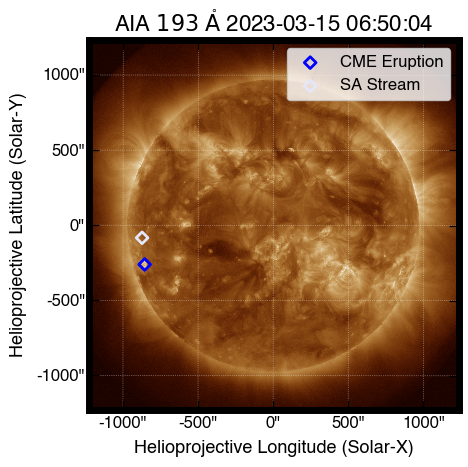

In [19]:
aia_map = map_seq[1]

fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

## FIGURE
aia_map.plot(axes=ax)
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(aia_map.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor='blue', linewidth=2, label='CME Eruption')
coords = SkyCoord(lon=5*u.deg, lat=-2*u.deg, radius=1*u.Rsun, frame=scoords.HeliographicCarrington, 
                  observer=psp_carrington.observer)
coords = coords.transform_to(aia_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(aia_map.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=scol, linewidth=2, label='SA Stream')
ax.legend()

# plt.savefig(os.path.join(FIG_DIR, 'cme_eruption.png'), bbox_inches='tight')

## CME MODEL

In [20]:
def ice_cream_model(alpha, r):
    
    # calculate semi-circle radius
    a = r * np.tan(alpha / 2) / (1 + np.tan(alpha / 2))

    # calculate triangle lengths
    l = np.sqrt((r - a)**2 + a**2)  # triangle leg
    h = r - a  # triangle height

    return a, l, h

In [21]:
# March 15, 2023 06:48 CME parameters
angular_width = 35*u.deg  # Replace with your actual angular width in degrees
initial_radius = 8.5*u.R_sun
velocity = 750*u.km/u.s  # velocity at radial position in km/s
accel = - 70 * u.km / (u.s ** 2)
num_steps = 10
time_step = 5 * u.hour # in seconds
# Eruption coordinates
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
coords = coords.transform_to(frame=scoords.HeliocentricInertial)
coords.representation_type="cartesian"
x0, y0 = coords.x.to(u.Rsun), coords.y.to(u.Rsun)
coords

<SkyCoord (HeliocentricInertial: obstime=2023-03-15T06:50:04.840): (x, y, z) in m
    (5.75059169e+08, 3.25015918e+08, -2.19288862e+08)>

## Setup

In [22]:
def parker_streamline(lon, time,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=250*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=100
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """

    # radius
    r = np.linspace(r0,rmax,sampling)
    # velocity 
    phi = (-w_s/(v_sw)*(r-r0)).to(u.deg) + lon*u.deg

    coords = SkyCoord(
        lon = phi.to(u.deg),
        lat = 0 * u.deg, 
        radius = r.to(u.Rsun),
        frame = scoords.HeliographicCarrington, 
        obstime=time,
        observer='self'
    )

    coords = coords.transform_to(scoords.HeliocentricInertial)
    coords.representation_type = 'cartesian'
    # x.append(coords.x.to(u.Rsun))
    # y.append(coords.y.to(u.Rsun))

    return coords.x.to(u.Rsun), coords.y.to(u.Rsun)

use = np.logical_and(psp_projected.lon.value>=ssw[0], psp_projected.lon.value<=ssw[1])
stream = [parker_streamline(lon, time=psp_projected[0].obstime.value,
        r0 = 2.5*u.Rsun, 
        rmax = 300*u.R_sun,
        v_sw = v*u.km/u.s) for lon,v in zip(np.linspace(9, 19, 100),np.linspace(300, 500, 100))]

In [23]:
### Trajectories
psp_coords = psp_inertial.transform_to(scoords.HeliocentricInertial)
psp_coords.representation_type="cartesian"

solo_coords = solo_inertial.transform_to(scoords.HeliocentricInertial)
solo_coords.representation_type="cartesian"

mms_carrington.representation_type='spherical'
mms_coords = mms_carrington.transform_to(scoords.HeliocentricInertial)
mms_coords.representation_type = 'cartesian'

# wind_carrington.representation_type='spherical'
wind_coords = wind_carrington.transform_to(scoords.HeliocentricInertial)
wind_coords.representation_type = 'cartesian'

## Movie!

In [24]:
# ### Set up axes
# fig, ax = plt.subplots(1, figsize=(12,15))
# dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
# dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)

# ### Gridlines / Axis Lables ETC for ax
# ax.set_aspect(1)
# rmax=300
# rgrids = np.linspace(60, rmax+1, 6)
# for R_ in rgrids  :
#     ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
#             R_*np.sin(np.linspace(0,2*np.pi,300)),
#             color="black",linestyle="--",alpha=0.5
#            )
# rmax=rmax    
# for phi in np.radians(np.linspace(0,360,11)) :
#     ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
#             color="black",linestyle=":",alpha=0.5
#            )
# ax.set_xticks(np.linspace(-rmax,rmax,11))
# ax.set_yticks(np.linspace(-rmax,rmax,11))
# ax.set_xlim([-rmax,rmax])
# ax.set_ylim([-rmax,rmax])
# ax.set_xlabel(r"$\rm X \; [R_\odot]$", fontsize=20)
# ax.set_ylabel(r"$\rm Y \; [R_\odot]$", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=18) 

# ############ --------------- TRAJECTORIES --------------- ############
# days=2
# cp, cs, cw, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
# label_cadence = 48*days
# cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
# c_cme = 'mistyrose'

# ### PARKER
# psp_coords.representation_type="cartesian"
# ax.plot(
#     psp_coords.x.to("R_sun"),
#     psp_coords.y.to("R_sun"),
#     color=cp,linewidth=2,zorder=10
# )
# ax.scatter(
#     psp_coords.x.to("R_sun")[::label_cadence],
#     psp_coords.y.to("R_sun")[::label_cadence],
#     color=dcol, marker='s',zorder=10
# )

# ### ORBITER
# solo_coords.representation_type="cartesian"
# ax.plot(
#     solo_coords.x.to("R_sun"),
#     solo_coords.y.to("R_sun"),
#     color=cs,linewidth=2,zorder=10
# )
# ax.scatter(
#     solo_coords.x.to("R_sun")[::label_cadence],
#     solo_coords.y.to("R_sun")[::label_cadence],
#     color=dcol, marker='s',zorder=10
# )

# # ### WIND
# # wind_coords.representation_type="cartesian"
# # ax.plot(
# #     wind_coords.x.to("R_sun"),
# #     wind_coords.y.to("R_sun"),
# #     color=cw,linewidth=2,label="Wind",zorder=10
# # )
# # ax.scatter(
# #     wind_coords.x.to("R_sun")[::label_cadence],
# #     wind_coords.y.to("R_sun")[::label_cadence],
# #     color=dcol, marker='s',zorder=10
# # )

# ### MMS
# mc=2880*days
# mms_coords.representation_type="cartesian"
# ax.plot(
#     mms_coords.x.to("R_sun"),
#     mms_coords.y.to("R_sun"),
#     color=cm,linewidth=2,label="MMS",zorder=10
# )
# ax.scatter(
#     mms_coords.x.to("R_sun")[::mc],
#     mms_coords.y.to("R_sun")[::mc],
#     color=dcol, marker='s',zorder=10
# )

# ### LABEL DATES
# for dt,pspc,soc,wsc in zip(dt_common[::label_cadence],
#                        psp_coords[::label_cadence],
#                        solo_coords[::label_cadence], 
#                        wind_coords[::label_cadence]) :
#     ax.text(pspc.x.to("R_sun").value,
#                  pspc.y.to("R_sun").value,
#                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
#                 verticalalignment="top",
#                 horizontalalignment="left",zorder=10,fontsize=16
#                )
#     ax.text(soc.x.to("R_sun").value,
#                  soc.y.to("R_sun").value,
#                  f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
#                  verticalalignment="bottom",
#                  horizontalalignment="right",zorder=10,
#                  fontsize=16
#                )
#     # ax.text(wsc.x.to("R_sun").value,
#     #                 wsc.y.to("R_sun").value,
#     #                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
#     #                 verticalalignment="top",
#     #                 horizontalalignment="left",zorder=10,fontsize=16
#     #             )
# for dt, mmsc in zip(mms_coords.obstime.datetime[::mc],
#                     mms_coords[::mc]):
#     ax.text(mmsc.x.to("R_sun").value,
#                     mmsc.y.to("R_sun").value,
#                     f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
#                     verticalalignment="top",
#                     horizontalalignment="left",zorder=10,fontsize=16
#                 )


# ############ SUN
# ax.scatter(0, 0, c='gold', marker='*', s=40, zorder=10)

# ############ CME
# ss, lw, mm = 10, 3, 'D'
# ec, erupc = 'tab:orange', 'tab:red'

# # Plot original triangle and semi circle
# a, l, h = ice_cream_model(angular_width, initial_radius)

# # eruption location
# r, p = np.sqrt(x0**2 + y0**2), np.arctan(y0/x0)

# ### SETUP FIGURE
# title = ax.set_title([], fontsize=22)
# psp, = ax.plot([], [], marker='*', ms=ss, c=cp, zorder=12)
# solo, = ax.plot([], [], marker='*', ms=ss, c=cs, zorder=12)
# mcoords, = ax.plot([], [], marker='*', ms=ss, c=cm, zorder=12)
# wcoords, = ax.plot([], [], marker='*', ms=ss, c=cw, zorder=12)
# cme_triangle, = ax.fill(np.zeros(3), np.zeros(3), color=c_cme)
# cme_semicircle, = ax.fill(np.zeros(100), np.zeros(100), color=c_cme)
# ll=10
# sa1, = ax.plot([], [], color=scol, lw=ll)
# sa2, = ax.plot([], [], color=scol, lw=ll)
# sa3, = ax.plot([], [], color=scol, lw=ll)
# sa4, = ax.plot([], [], color=scol, lw=ll)
# sa5, = ax.plot([], [], color=scol, lw=ll)
# sa6, = ax.plot([], [], color=scol, lw=ll)
# sa7, = ax.plot([], [], color=scol, lw=ll)
# sa8, = ax.plot([], [], color=scol, lw=ll)
# sa9, = ax.plot([], [], color=scol, lw=ll)
# sa10, = ax.plot([], [], color=scol, lw=ll)
# sa11, = ax.plot([], [], color=scol, lw=ll)
# sa12, = ax.plot([], [], color=scol, lw=ll)
# sa13, = ax.plot([], [], color=scol, lw=ll)
# sa14, = ax.plot([], [], color=scol, lw=ll)
# sa15, = ax.plot([], [], color=scol, lw=ll)
# sa16, = ax.plot([], [], color=scol, lw=ll)
# sa17, = ax.plot([], [], color=scol, lw=ll)
# sa18, = ax.plot([], [], color=scol, lw=ll)
# sa19, = ax.plot([], [], color=scol, lw=ll)
# sa20, = ax.plot([], [], color=scol, lw=ll)


# ### LEGEND ###
# psp_patch = mpatches.Patch(facecolor=cp, edgecolor='k', label='Parker Solar Probe')
# solo_patch = mpatches.Patch(facecolor=cs, edgecolor='k', label='Solar Orbiter')
# mms_patch = mpatches.Patch(facecolor=cm, edgecolor='k', label='1 AU')
# # wind_patch = mpatches.Patch(facecolor=cw, edgecolor='k', label='Wind')
# cme_patch = mpatches.Patch(facecolor=c_cme, edgecolor='k', label='CME Model')
# sa_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label='SA Stream') # wind_patch, 
# leg0 = ax.legend(handles=[psp_patch, solo_patch, mms_patch, cme_patch, sa_patch], loc='upper left', fontsize=20)
# ax.add_artist(leg0)

# ### watermark ###
# ax.text(0.88, 0.02, 'Tamar Ervin', transform=ax.transAxes,
#         fontsize=12, color='gray', alpha=0.5,
#         ha='left', va='bottom')

# ### ANIMATION
# def animate(i):
#     # time
#     dt = dt_common[i]

#     # title
#     title.set_text(dt)

#     # psp trajectory
#     psp.set_data([psp_coords[i].x.to("R_sun").value], [psp_coords[i].y.to("R_sun").value])

#     # solo trajectory
#     solo.set_data([solo_coords[i].x.to("R_sun").value], [solo_coords[i].y.to("R_sun").value])

#     # mms trajectory
#     if datetime.datetime(2023, 3, 21, 0, 0, 0) < dt < datetime.datetime(2023, 4, 1, 0, 0, 0):
#         mcoords.set_data([mms_coords[60*(i-288)].x.to("R_sun").value], [mms_coords[60*(i-288)].y.to("R_sun").value])

#     # wind trajectory
#     # wcoords.set_data([wind_coords[i].x.to("R_sun").value], [wind_coords[i].y.to("R_sun").value])

#     # SA stream
#     stream = [parker_streamline(lon, time=psp_projected[i].obstime.value,
#         r0 = 2.5*u.Rsun, 
#         rmax = 400*u.R_sun,
#         v_sw = v*u.km/u.s) for lon,v in zip(np.linspace(9, 19, 20),np.linspace(350, 450, 20))]
#     x, y = stream[0], stream[1]
#     sa1.set_data([stream[0][0]], [stream[0][1]])
#     sa2.set_data([stream[1][0]], [stream[1][1]])
#     sa3.set_data([stream[2][0]], [stream[2][1]])
#     sa4.set_data([stream[3][0]], [stream[3][1]])
#     sa5.set_data([stream[4][0]], [stream[4][1]])
#     sa6.set_data([stream[5][0]], [stream[5][1]])
#     sa7.set_data([stream[6][0]], [stream[6][1]])
#     sa8.set_data([stream[7][0]], [stream[7][1]])
#     sa9.set_data([stream[8][0]], [stream[8][1]])
#     sa10.set_data([stream[9][0]], [stream[9][1]])
#     sa11.set_data([stream[10][0]], [stream[10][1]])
#     sa12.set_data([stream[11][0]], [stream[11][1]])
#     sa13.set_data([stream[12][0]], [stream[12][1]])
#     sa14.set_data([stream[13][0]], [stream[13][1]])
#     sa15.set_data([stream[14][0]], [stream[14][1]])
#     sa16.set_data([stream[15][0]], [stream[15][1]])
#     sa17.set_data([stream[16][0]], [stream[16][1]])
#     sa18.set_data([stream[17][0]], [stream[17][1]])
#     sa19.set_data([stream[18][0]], [stream[18][1]])
#     sa20.set_data([stream[19][0]], [stream[19][1]])

    
#     # cme!
#     time_difference = dt - datetime.datetime(2023, 3, 15, 6, 48, 0)
#     if time_difference > datetime.timedelta(seconds=10):
#         time_step = time_difference.total_seconds() // 60
#         new_radius = initial_radius + i * velocity * time_step * u.minute 
#         a, l, h = ice_cream_model(angular_width, new_radius)
#         p1 = p + np.arctan(a / h)
#         p2 = p - np.arctan(a / h)
#         x1, y1 = h * np.cos(p1), h * np.sin(p1)
#         x2, y2 = h * np.cos(p2), h * np.sin(p2)
#         if np.logical_and(x1 < 200*u.Rsun, y1 < 200*u.Rsun):
#             point1 = np.array([x1.value, y1.value])
#             point2 = np.array([x2.value, y2.value])
#             # cme1.set_data([x1.value], [y1.value]) # c=cc[i%6], marker=mm, s=ss, label=f"CME Model: {dt.hour:02d}:{dt.minute:02d}"
#             # cme2.set_data([x2.value], [y2.value])
#             vertices = np.array([np.array([0, 0]), point1, point2])
#             cme_triangle.set_xy(vertices)

#             # semicircle coordinates
#             theta = np.linspace(0, np.pi, 100)
#             flat_angle = np.arctan2(point2[1] - point1[1], point2[0] - point1[0])

#             radius = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) / 2
#             center = (point1 + point2) / 2
#             x_sem = center[0] + radius * np.cos(theta + flat_angle)
#             y_sem = center[1] + radius * np.sin(theta + flat_angle)

#             cme_semicircle.set_xy(np.column_stack([x_sem, y_sem]))

#     return title, psp, solo, cme_triangle, cme_semicircle, sa1, sa2, sa3, sa4, sa5, sa6, sa7, sa8, sa9, sa10, sa11, 
#     sa12, sa13, sa14, sa15, sa16, sa17, sa18, sa19, sa20,

# ### create and save animation
# anim = animation.FuncAnimation(fig, animate, init_func=None, frames=len(dt_common), interval=200, repeat=True, blit=True)
# anim.save(os.path.join(FIG_DIR, 'cme_traj.gif'))

# plt.show()

# Figure 7: Six Panels Movie Cutout

In [25]:
ss, lw, mm = 10, 3, 'D'
def plot_traj(ax, datet, rmax=300):
    i = np.where(datet == dt_common)[0][0]
    ### Gridlines / Axis Lables ETC for ax
    ax.set_aspect(1)
    rgrids = np.linspace(rmax/5, rmax+1, 6)
    for R_ in rgrids  :
        ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
                R_*np.sin(np.linspace(0,2*np.pi,300)),
                color="black",linestyle="--",alpha=0.5
            )
    rmax=rmax    
    for phi in np.radians(np.linspace(0,360,11)) :
        ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
                color="black",linestyle=":",alpha=0.5
            )
    ax.set_xticks(np.linspace(-rmax,rmax,11))
    ax.set_yticks(np.linspace(-rmax,rmax,11))
    ax.set_xlim([-rmax,rmax])
    ax.set_ylim([-rmax,rmax])
    ax.set_xlabel(r"$\rm X \; [R_\odot]$", fontsize=20)
    ax.set_ylabel(r"$\rm Y \; [R_\odot]$", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 

    ############ --------------- TRAJECTORIES --------------- ############
    days=2
    cp, cs, cw, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
    label_cadence = 48*days
    cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
    c_cme = 'mistyrose'

    ### PARKER
    psp_coords.representation_type="cartesian"
    ax.plot(
        psp_coords.x.to("R_sun"),
        psp_coords.y.to("R_sun"),
        color=cp,linewidth=2,zorder=10
    )

    ### ORBITER
    solo_coords.representation_type="cartesian"
    ax.plot(
        solo_coords.x.to("R_sun"),
        solo_coords.y.to("R_sun"),
        color=cs,linewidth=2,zorder=10
    )

    ### MMS
    mc=2880*days
    mms_coords.representation_type="cartesian"
    ax.plot(
        mms_coords.x.to("R_sun"),
        mms_coords.y.to("R_sun"),
        color=cm,linewidth=2,label="MMS",zorder=10
    )

    # psp trajectory
    ax.plot(psp_coords[i].x.to("R_sun").value, psp_coords[i].y.to("R_sun").value, marker='*', ms=ss, c=cp, zorder=12)

    # solo trajectory
    ax.plot(solo_coords[i].x.to("R_sun").value, solo_coords[i].y.to("R_sun").value, marker='*', ms=ss, c=cs, zorder=12)

    # mms trajectory
    if datetime.datetime(2023, 3, 21, 0, 0, 0) < datet < datetime.datetime(2023, 4, 1, 0, 0, 0):
        ax.plot(mms_coords[60*(i-288)].x.to("R_sun").value, mms_coords[60*(i-288)].y.to("R_sun").value, marker='*', ms=ss, c=cm, zorder=12)


def plot_cme_sa(ax, datet):
    i = np.where(datet == dt_common)[0][0]
    
    # SA stream
    stream = [parker_streamline(lon, time=psp_projected[i].obstime.value,
        r0 = 2.5*u.Rsun, 
        rmax = 500*u.R_sun,
        v_sw = v*u.km/u.s) for lon,v in zip(np.linspace(9, 19, 20),np.linspace(350, 450, 20))]
    [ax.plot(ss[0], ss[1], c=scol, lw=4) for ss in stream]
    
    # cme!
    ############ SUN
    ax.scatter(0, 0, c='gold', marker='*', s=40, zorder=10)

    ############ CME
    ss, lw, mm = 10, 3, 'D'
    ec, erupc = 'tab:orange', 'tab:red'

    # Plot original triangle and semi circle
    a, l, h = ice_cream_model(angular_width, initial_radius)

    # eruption location
    r, p = np.sqrt(x0**2 + y0**2), np.arctan(y0/x0)
    
    time_difference = datet - datetime.datetime(2023, 3, 15, 6, 48, 0)
    if time_difference > datetime.timedelta(seconds=10):
        time_step = time_difference.total_seconds() // 60
        new_radius = initial_radius + i * velocity * time_step * u.minute 
        a, l, h = ice_cream_model(angular_width, new_radius)
        p1 = p + np.arctan(a / h)
        p2 = p - np.arctan(a / h)
        x1, y1 = h * np.cos(p1), h * np.sin(p1)
        x2, y2 = h * np.cos(p2), h * np.sin(p2)
        # if np.logical_and(x1 < 200*u.Rsun, y1 < 200*u.Rsun):
        point1 = np.array([x1.value, y1.value])
        point2 = np.array([x2.value, y2.value])
        vertices = np.array([np.array([0, 0]), point1, point2])
        ax.fill(vertices[:, 0], vertices[:, 1], color=c_cme)

        # Plot the semicircle
        theta = np.linspace(0, np.pi, 100)
        flat_angle = np.arctan2(point2[1] - point1[1], point2[0] - point1[0])

        radius = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) / 2
        center = (point1 + point2) / 2
        x_sem = center[0] + radius * np.cos(theta + flat_angle)
        y_sem = center[1] + radius * np.sin(theta + flat_angle)
        ax.fill(x_sem, y_sem, color=c_cme)

In [26]:
### Set up axes
fig = plt.figure(figsize=(30, 30))
fig.tight_layout()
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.1) 

days=2
cp, cs, cw, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
label_cadence = 48*days
cc = ['r', 'orange', 'green', 'blue', 'purple', 'pink']
c_cme = 'mistyrose'

dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)

############ --------------- AIA IMAGE --------------- ############
ax = fig.add_subplot(grid[0, 0], projection=aia_map)

### AIA MAP
aia_map.plot(axes=ax)
coords = SkyCoord(Tx=-856*u.arcsec, Ty=-261*u.arcsec, frame=aia_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(aia_map.wcs)

### ERUPTION SOURCE
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor='lightblue', s=30, linewidth=2, label='CME Eruption')
# Add an arrow and text annotation
arrow_props = dict(facecolor='lightblue', arrowstyle='->', edgecolor='lightblue')
ax.annotate('CME Eruption Source', xy=(pixel_coords_x+5, pixel_coords_y+5), xytext=(pixel_coords_x + 100, pixel_coords_y + 100),
            arrowprops=arrow_props, color='lightblue', fontsize=24, fontweight='bold')

### LABELS 
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel('Helioprojective Longitude (Solar-X)', fontsize=20)
ax.set_ylabel('Helioprojective Latitude (Solar-Y)',fontsize=20)
ax.set_title('AIA 193${\AA}$ 2023-03-15 06:50', fontsize=22)
ax.text(0.93, 0.97, '(a)', transform=ax.transAxes, fontsize=20, va='top', ha='left', color='white')

############ --------------- CME MODEL --------------- ############
dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)

#### TIME ONE: CME ONSET 
ax = fig.add_subplot(grid[0, 1])
ax.set_title('2023-03-15 07:00', fontsize=22)
plot_traj(ax, datet=datetime.datetime(2023, 3, 15, 7, 0, 0), rmax=60)
plot_cme_sa(ax, datet=datetime.datetime(2023, 3, 15, 7, 0, 0))

### LEGEND ###
psp_patch = mpatches.Patch(facecolor=cp, edgecolor='k', label='Parker Solar Probe')
solo_patch = mpatches.Patch(facecolor=cs, edgecolor='k', label='Solar Orbiter')
mms_patch = mpatches.Patch(facecolor=cm, edgecolor='k', label='1 AU')
leg0 = ax.legend(handles=[psp_patch, solo_patch, mms_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)
ax.text(0.93, 0.97, '(b)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### TIME TWO: CME EXTENT 
ax = fig.add_subplot(grid[1, 0])
ax.set_title('2023-03-15 10:30', fontsize=22)
datet=datetime.datetime(2023, 3, 15, 10, 30, 0)
plot_traj(ax, datet, rmax=60)
plot_cme_sa(ax, datet)

cme_patch = mpatches.Patch(facecolor=c_cme, edgecolor='k', label='CME Model')
sa_patch = mpatches.Patch(facecolor=scol, edgecolor='k', label='SA Stream') 
leg0 = ax.legend(handles=[cme_patch, sa_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)
ax.text(0.93, 0.97, '(c)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### TIME THREE: PARKER PASSING
ax = fig.add_subplot(grid[1, 1])
ax.set_title('2023-03-16 18:00', fontsize=22)
datet=datetime.datetime(2023, 3, 16, 18, 00, 0)
plot_traj(ax, datet, rmax=60)
plot_cme_sa(ax, datet)
ax.text(0.93, 0.97, '(d)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### TIME FOUR: ORBITER PASSING
ax = fig.add_subplot(grid[2, 0])
ax.set_title('2023-03-24 12:00', fontsize=22)
datet=datetime.datetime(2023, 3, 24, 12, 00, 0)
plot_traj(ax, datet, rmax=300)
plot_cme_sa(ax, datet)
ax.text(0.93, 0.97, '(e)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### TIME FIVE: 1AU PASSING
ax = fig.add_subplot(grid[2, 1])
ax.set_title('2023-03-28 00:00', fontsize=22)
datet=datetime.datetime(2023, 3, 28, 0, 0, 0)
plot_traj(ax, datet, rmax=300)
plot_cme_sa(ax, datet)
ax.text(0.93, 0.97, '(f)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

plt.savefig(os.path.join('figures', 'fig7.png'), bbox_inches='tight')
plt.savefig(os.path.join('eps_figures', 'fig7.eps'), bbox_inches='tight')
plt.show()

08-Mar-24 10:52:45: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
08-Mar-24 10:52:45: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Deprecated

In [ ]:
for i, vv in enumerate(data):
    ### PLOT THE DATA
    axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
    axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
    axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
    # axs[i].step(mmsdownl.sslon, mmsdownl[vv], c=cm, linewidth=lw, zorder=2)

    axs[i].set_xticklabels([])

    ### ADD Y-LABEL
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 

    ### ADD X-LIMITS
    axs[i].set(xlim=(-5, 35), xticks=np.arange(0, 31, step=10))

    ### ADD THE GRID
    axs[i].grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS ###
    regions = [
        (loc_hcs[0], loc_hcs[1], hcol),
        (loc_hcs1[0], loc_hcs1[1], hcol),
        (ssw[0], ssw[1], scol),
        (fsw[0], fsw[1], fcol)
    ]

    lines = [
        loc_hcs[0],
        loc_hcs[1],
        loc_hcs1[0],
        loc_hcs1[1],
        ssw[0],
        ssw[1],
        fsw[0],
        fsw[1]
    ]

    ### PLOT LINES AND REGIONS ###
    for line in lines:
        axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

    for region in regions:
        axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)
